# Large attachment failures in requesting TPP practices

Questions:

- Can we reliably identify GP2GP conversations that have failed due to TPP’s attachment size constraints?
- For such conversations, can we identify the size of the largest attachment?
- Given a proposed attachment size limit, can we estimate the number of transfer failures that will occur due to breaching this limit?
- Are there any trends in attachment size that may impact on our findings in the future? (e.g. is there a trend for attaching larger files to patient records?)

In [24]:
import paths
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Coverage of large message failures in the MI data

- We know that the MI data isn't always reliable
- We assume that the `spine2vfmmonitor` index in NMS is more complete, as NHSD has complete observability for it
- We believe that by comparing large message error volumes in MI and in spine, we should be able to get some insight into the value of the MI data for addressing these issues

### According to Spine

NMS query to retrieve all large message errors from spine (regardless of whether generated by the sender or the requestor) for all suppliers:
```
index="spine2vfmmonitor" ackExceptionCode=30
| stats count, dc(conversationID) as distinct_conversations
```

Running this query, filtered by the Date time range 1st May 2020 00:00:00.000 to 31th August 2020 23:59:59.000:

```
count: 5048
distinct_conversations: 4785
```

That is, there were `5048` spine messages with `ackExceptionCode = 30` (i.e. Application Acknowledgement messages with `large message general failures` according to the gp2gp spec), and these occurred over `4785` unique conversations.

Interestingly, there were a few conversations that had multiple messages with error code 30; the table below shows the top 5.

By running the Splunk query

```
index="spine2vfmmonitor" ackExceptionCode=30
| stats count by conversationID
| sort count
```

| conversationID | number of code 30 messages |
|----------------|----------------------------|
| 1624A100-A1A0-11EA-AFDB-913D42A87760 | 25 |
| CDE45270-C821-11EA-8511-8374B7AFD3E3 | 21 |
| E878B990-D7E5-11EA-9971-49A19FBDE454 | 21 |
| 7332E150-D237-11EA-82CF-13FF21760BD2 | 20 |
| 4B21A520-C5DA-11EA-A64D-B366590C2A6F | 14 |


TODO:

- codes `29` and `31` are also associated with large message errors -- do we see any of these in practice? associated with TPP?
- If we could distinguish between the Sender and Requestor practice in spine, we could break down the failures as to whether they occurred on the sender side or requestor side; only the latter corresponds to TPP attachment failures.

### According to the MI data

For the MI data, we have both the 'sender' and 'requestor' views of each conversation.  All the following queries run for 1st May 2020 - 31st August 2020 only for data received from TPP.

#### From the sender perspective - looking at request acknowledgement errors

Note: To create a view with sender records (`mi_sr`) in AWS Athena see [Create SR view](/athena/create_sr_view.sql).

```sql
SELECT count(ConversationID) AS conversation_count,
         count(DISTINCT ConversationID) AS distinct_conversation_count
FROM mi_sr
WHERE RequestAckCode='30'
        AND from_iso8601_timestamp(RequestTime)
    BETWEEN from_iso8601_timestamp('2020-05-01T00:00:00')
        AND from_iso8601_timestamp('2020-08-31T23:59:59')
```

Results:
```
conversation_count: 3649
distinct_count: 3649
```

#### From the requestor perspective - looking at request errors

Note: To create a view with requester records (`mi_rr`) in AWS Athena see [Create RR view](/athena/create_rr_view.sql).

```sql
SELECT count(ConversationID) AS conversation_count,
         count(DISTINCT ConversationID) AS distinct_conversation_count
FROM mi_rr
WHERE RequestErrorCode='30'
        AND from_iso8601_timestamp(RequestTime)
    BETWEEN from_iso8601_timestamp('2020-05-01T00:00:00')
        AND from_iso8601_timestamp('2020-08-31T23:59:59')
```

Results:

```
conversation_count: 0
distinct_conversation_count: 0
```

#### From the requestor perspective - looking at extract acknowledgement errors

```sql
SELECT count(ConversationID) AS conversation_count,
         count(DISTINCT ConversationID) AS distinct_conversation_count
FROM mi_rr
WHERE ExtractAckCode='30'
        AND from_iso8601_timestamp(RequestTime)
    BETWEEN from_iso8601_timestamp('2020-05-01T00:00:00')
        AND from_iso8601_timestamp('2020-08-31T23:59:59')
```

Results:

```
conversation_count: 1110
distinct_count: 1110
```

#### Merging all sender and requester large attachment failures

Create a view with sender large attachment failures

```sql
CREATE OR REPLACE VIEW sr_large_attachment_failures AS
SELECT ConversationID
FROM mi_sr
WHERE RequestAckCode='30'
        AND from_iso8601_timestamp(RequestTime)
    BETWEEN from_iso8601_timestamp('2020-05-01T00:00:00')
        AND from_iso8601_timestamp('2020-08-31T23:59:59')
```

Create a view with requester large attachment failures

```sql
CREATE OR REPLACE VIEW rr_large_attachment_failures AS
SELECT ConversationID
FROM mi_rr
WHERE (RequestErrorCode='30'
        OR ExtractAckCode='30')
        AND from_iso8601_timestamp(RequestTime)
    BETWEEN from_iso8601_timestamp('2020-05-01T00:00:00')
        AND from_iso8601_timestamp('2020-08-31T23:59:59')
```

Join and count sender and requester large attachment failures

```sql
SELECT COUNT(*)
FROM 
    (SELECT ConversationID
    FROM rr_large_attachment_failures) AS a FULL OUTER
JOIN 
    (SELECT ConversationID
    FROM sr_large_attachment_failures) AS b
    ON a.ConversationID=b.ConversationID;
```

Results:

```
distinct_conversations: 4759
```

### Conclusion

```
Spine large attachment failures for all suppliers: 4785
MI large attachment failures for TPP: 4759
```

The results from the MI data are incredibly close to the Spine results --- the discrepancy could be explained by having only TPP MI data available at the time of running the above queries.
    - We can assume from this that only 26 other conversations had a general large message failure that were associated with suppliers other than TPP. 

**Thus: we can be confident in using the MI data to analyse 'error code 30' events --- i.e. `large message general failures`**.

## Impact of increasing TPP attachment size limit

The `RequestErrorDescription` includes text that identifies the size of the largest attachment, e.g.:

> Attachment size : 62546892 is larger than TPP limit : 52428800

We found that there were 178 conversations that had RequestErrorDescription as "Attachment size : ... is larger than TPP limit", during Feburary 2020 for TPP MI Data. 

```sql
SELECT count(ConversationID) AS conversation_count,
         count(DISTINCT ConversationID) AS distinct_conversation_count
FROM "mi_rr"
WHERE REGEXP_LIKE(RequestErrorDescription, 'Attachment size : (\d+) is larger than TPP limit : (\d+)')
        AND from_iso8601_timestamp(RequestTime)
    BETWEEN from_iso8601_timestamp('2020-05-01T00:00:00')
        AND from_iso8601_timestamp('2020-08-31T23:59:59')
```

Results:
```
count: 	1107
distinct_count: 1107
```

We can use the following query to extract the sizes of these attachments, and get some insight into the impact of increasing the TPP attachment limit:

```sql
SELECT RequestorODS,
         RequestTime,
         ConversationID,
         RequestErrorDescription,
         CAST(REGEXP_EXTRACT (RequestErrorDescription,
         'Attachment size : (\d+) is larger than TPP limit : (\d+)', 1) AS INTEGER) / (1024*1024) AS attachment_size_mb, CAST(REGEXP_EXTRACT (RequestErrorDescription, 'Attachment size : (\d+) is larger than TPP limit : (\d+)', 2) AS INTEGER) / (1024*1024) AS attachment_limit_mb
FROM "mi_rr"
WHERE REGEXP_LIKE(RequestErrorDescription, 'Attachment size : (\d+) is larger than TPP limit : (\d+)')
        AND from_iso8601_timestamp(RequestTime)
    BETWEEN from_iso8601_timestamp('2020-05-01T00:00:00')
        AND from_iso8601_timestamp('2020-08-31T23:59:59')
```

In [25]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt

In [26]:
import data

In [27]:
attachment_sizes_df = pd.read_csv(
    data.PRMT_1145_attachment_sizes.path,
    index_col="ConversationID"
)

In [28]:
attachment_sizes_df.columns

Index(['RequestorODS', 'RequestTime', 'RequestErrorDescription',
       'attachment_size_mb', 'attachment_limit_mb'],
      dtype='object')

In [29]:
len(attachment_sizes_df)

1107

In [30]:
sorted_attachment_sizes_df = attachment_sizes_df[["RequestTime", "RequestorODS", "attachment_size_mb", "attachment_limit_mb"]].sort_values("attachment_size_mb", ascending=False)
sorted_attachment_sizes_df


,RequestTime,RequestorODS,attachment_size_mb,attachment_limit_mb
ConversationID,,,,
97CB7E80-A0FC-11EA-B384-995F13BCC22B,2020-05-28T17:02:11,J81033,444,60
733931E0-A0BE-11EA-88E4-0FC2A1E8C61B,2020-05-28T09:37:24,L84003,320,60
79CC9AC0-C291-11EA-8D1A-CFF70F6867E9,2020-07-10T10:41:04,J81081,307,60
C0116AC0-CDD0-11EA-9E94-6BEB2382BB60,2020-07-24T18:11:43,A86010,285,60
E878B990-D7E5-11EA-9971-49A19FBDE454,2020-08-06T14:08:22,C84053,262,60
...,...,...,...,...
A36EBD30-E394-11EA-8D7C-DB4ED32B6A8A,2020-08-21T10:56:52,E82005,60,60
6E355010-D0E4-11EA-9730-6D0AA2C505D7,2020-07-28T16:10:10,A86004,60,60
06CA8D00-E1FB-11EA-AEF7-41244474C37C,2020-08-19T10:04:45,B85031,60,60


Note we found that the TPP attachment size limit was always 60mb during this period of time (by sorting by attachment_limit_mb, there were no variations from 60)

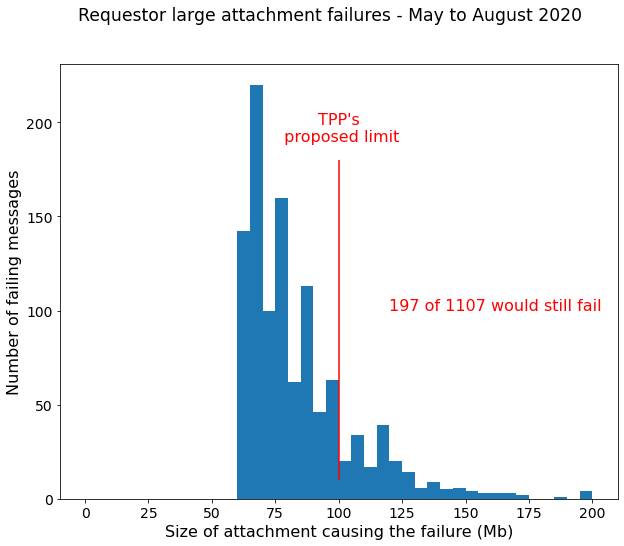

In [31]:
limit = 100

fig = (attachment_sizes_df[["attachment_size_mb"]]
 .plot.hist(
     bins=np.linspace(0, 200, 41),
     figsize=(10,8),
     legend=False
 )
);

plt.suptitle("Requestor large attachment failures - May to August 2020", ha="center", fontsize="xx-large")

plt.xlabel("Size of attachment causing the failure (Mb)", size=16);
plt.xticks(fontsize=14)
plt.ylabel("Number of failing messages", size=16);
plt.yticks(fontsize=14)
plt.vlines([limit], 10, 180, color="r");
plt.text(100, 190, "TPP's\n proposed limit", fontsize=16, color="r", horizontalalignment='center')

number_greater_than_limit = len(
    attachment_sizes_df
    .loc[attachment_sizes_df["attachment_size_mb"] > limit]
)
total = len(attachment_sizes_df)
plt.text(120, 100, f"{number_greater_than_limit} of {total} would still fail", fontsize=16, color="r")
plt.savefig("../temp_outputs/largest_attachment_size_histogram.png")

In [ ]:
Interestingly, around 17.8% of transfers would still fail between May to August 2020 compared to around 10.2% between May to August 2019.

### Other things found
Since there were 2 RR records with ExtractAckCode=30 that did not have the RequestErrorDescription as "'Attachment size (after decompression)... is larger than TPP limit'", we ran the following query to see what the error description was instead:

```sql
SELECT *
FROM "mi_rr"
WHERE ExtractAckCode='30'
        AND NOT REGEXP_LIKE(RequestErrorDescription, 'Attachment size : (\d+) is larger than TPP limit : (\d+)')
        AND from_iso8601_timestamp(RequestTime)
    BETWEEN from_iso8601_timestamp('2020-02-01T00:00:00')
        AND from_iso8601_timestamp('2020-02-29T23:59:59')
```

We found the following RequestErrorDescription value instead that could be worth looking into

| ConversationID | RequestErrorDescription |
|-------|------|
| A118FC10-4BE3-11EA-AB38-773522C33F25 | Extract size : 778725412 is larger than TPP limit : 524288000 |
| 93D3EC40-5A34-11EA-AD93-A72EC9F36AD5| Extract size : 673418708 is larger than TPP limit : 524288000 |


Whilst waiting for the TPP MI data to be delivered, we first focused on the Feburary 2020.

## Coverage of large message failures in the MI data (where error code was 30)

### According to Spine:
- There were 1200 spine messages with ackExceptionCode = 30 (i.e. Application Acknowledgement messages with large message general failures according to the gp2gp spec), and these occurred over 1139 unique conversations.
    - This was filtered by the Date time range 1st Feb 2020 00:00:00.000 to 29th Feb 2020 23:59:59.000
- Interestingly, one conversation (`440CAD30-5879-11EA-AAFF-6168D3AA4F1F`) was responsible for `54` of the messages with `ackExceptionCode=30`. Requesting practice `fromPartyID` field contained `YGA`, therefore we assume that this is a TPP practice.

| conversationID | number of code 30 messages |
|----------------|----------------------------|
|440CAD30-5879-11EA-AAFF-6168D3AA4F1F	 | 54 |
|3FCF25F0-4CC5-11EA-9FFE-8500E7C8EA1C	 | 3  |
|44CD4320-48D8-11EA-9E3E-2961FF2D25D3	 | 2  |
|4A61FD90-5179-11EA-9101-1FE05E86F508	 | 2  |

### According to MI Data:
- From the sender perspective - looking at request acknowledgement errors
    - There were 945 distinct conversations
- From the requestor perspective - looking at request errors
    - There were 0 conversations
- From the requestor perspective - looking at extract acknowledgement errors
    - There were 182 distinct conversations
- Merging all sender and requester large attachment failures
    - There were 1127 distinct conversations

### Conclusion
    - Spine: large attachment failures for all suppliers: 1139 compared to MI large attachment failures for TPP: 1127
    - The results from the MI data are very close to the Spine results --- the discrepancy could be explained by having only TPP MI data available at the time of running the above queries.

## Impact of increasing TPP attachment size limit
- There were 180 distinct conversations that had RequestErrorDescription as "Attachment size : ... is larger than TPP limit"


![Feb 2020 large attachment failure histogram](../assets/feb_2020_large_attachment_failure_histogram.png)

    - Note this caveat: The attachment size limit was 100Mb from 1st - 10th Feb and then it was decreased to 60Mb.